In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import PIL
import matplotlib.pyplot as plt

In [2]:
from utils import get_model
import torch

weight_dir = 'model_.pt'
model = get_model(weight_dir, n_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


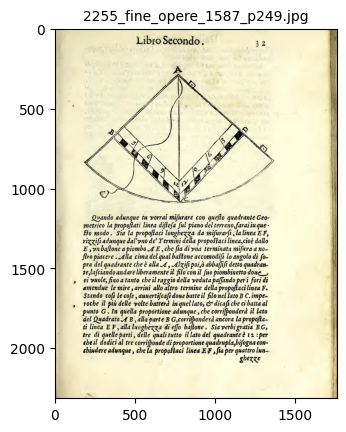

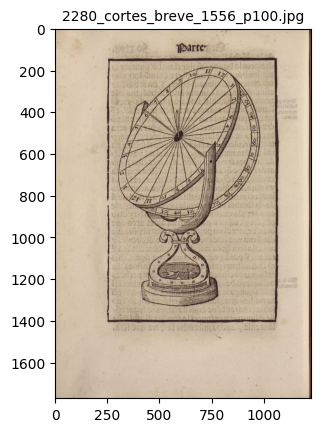

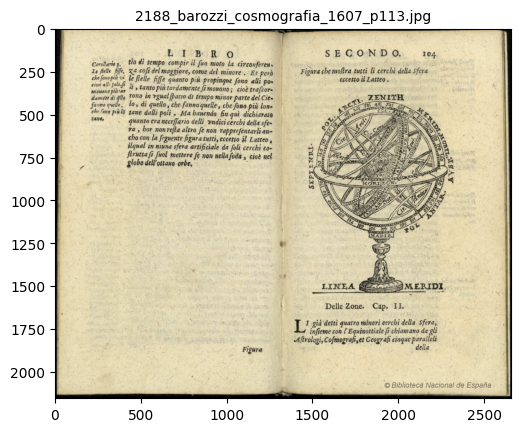

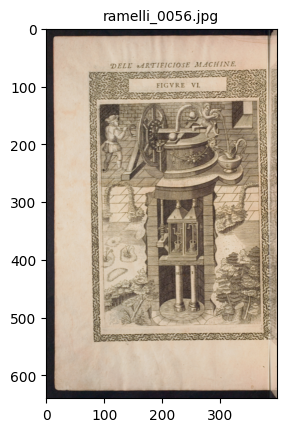

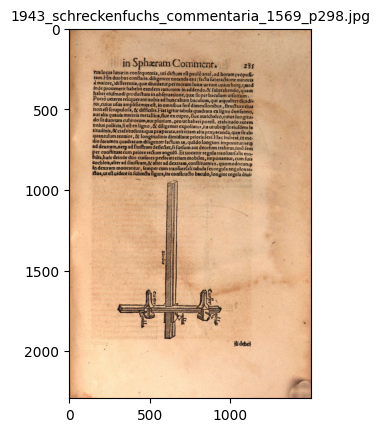

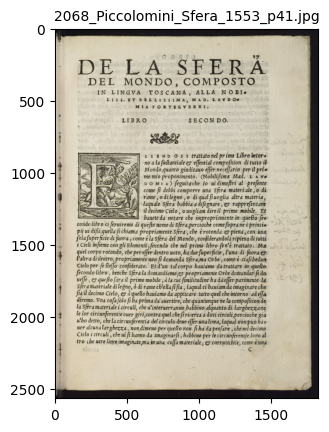

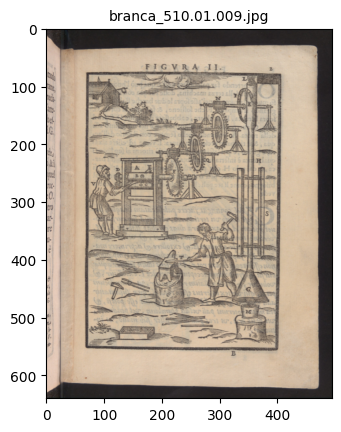

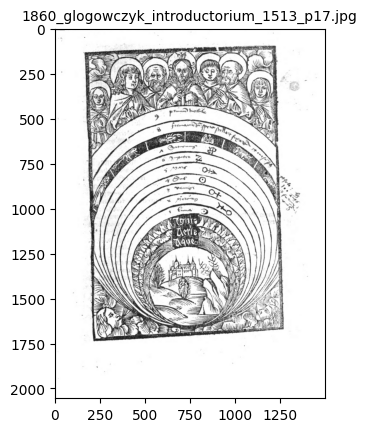

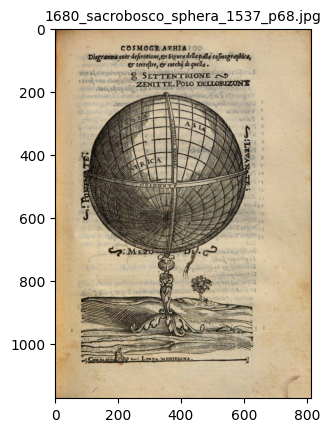

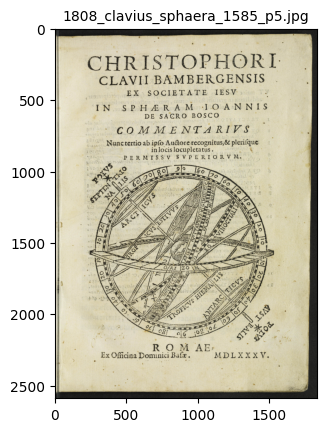

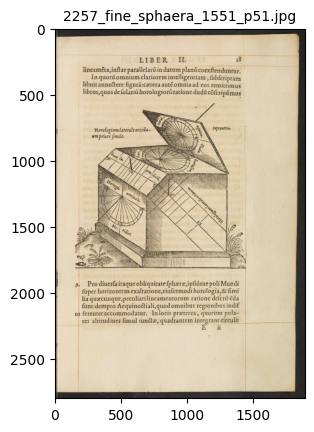

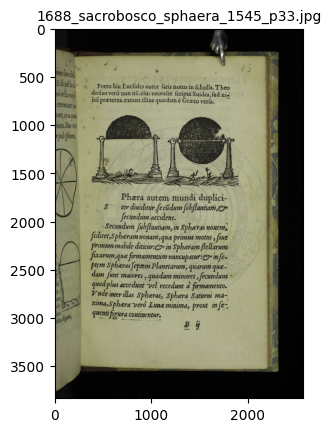

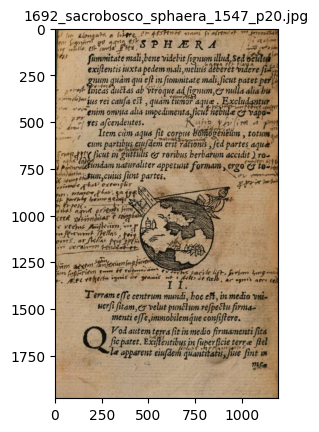

In [4]:
data_root = 'sample_data/pages'

for file in glob.glob(os.path.join(data_root, '*', 'raw', '*.jpg')):
    pil = PIL.Image.open(file)
    image = np.array(pil)
    plt.imshow(image)
    plt.title(os.path.split(file)[1], fontsize=10)
    plt.show()

In [5]:
from dataloaders.proc_utils import read_image_gray, binarize, write_image_binary
# Load
from dataloaders.instrument_pages import sphaera_instruments_page
from dataloaders.dataset import PageDataset, PageDatasetBoxes
from utils import set_up_dir

csv_instruments = 'sample_data/data_subset.csv'
df_instruments = pd.read_csv(csv_instruments)

from dataloaders.proc_utils import read_image_gray, binarize, write_image_binary

for file in glob.glob(os.path.join(data_root, '*', 'raw', '*.jpg')):
    file_path_bin = file.replace('raw', 'processed')

    print(file_path_bin)
    # Binarize
    if not os.path.exists(file_path_bin):

        set_up_dir(os.path.split(file_path_bin)[0])
        image = read_image_gray(file)
        image = binarize(image)
        write_image_binary(file_path_bin, image)

# Collecting data
dataloader = sphaera_instruments_page(data_root=data_root, source=df_instruments, binarize=False, refsize=800, removemean=True, train_split=1., extra_data = None, loader = PageDatasetBoxes )  


sample_data/pages/2255_fine_opere_1587/processed/2255_fine_opere_1587_p249.jpg
sample_data/pages/2280_cortes_breve_1556/processed/2280_cortes_breve_1556_p100.jpg
sample_data/pages/2188_barozzi_cosmografia_1607/processed/2188_barozzi_cosmografia_1607_p113.jpg
sample_data/pages/ramelli/processed/ramelli_0056.jpg
sample_data/pages/1943_schreckenfuchs_commentaria_1569/processed/1943_schreckenfuchs_commentaria_1569_p298.jpg
sample_data/pages/2068_Piccolomini_Sfera_1553/processed/2068_Piccolomini_Sfera_1553_p41.jpg
sample_data/pages/branca/processed/branca_510.01.009.jpg
sample_data/pages/1860_glogowczyk_introductorium_1513/processed/1860_glogowczyk_introductorium_1513_p17.jpg
sample_data/pages/1680_sacrobosco_sphera_1537/processed/1680_sacrobosco_sphera_1537_p68.jpg
sample_data/pages/1808_clavius_sphaera_1585/processed/1808_clavius_sphaera_1585_p5.jpg
sample_data/pages/2257_fine_sphaera_1551/processed/2257_fine_sphaera_1551_p51.jpg
sample_data/pages/1688_sacrobosco_sphaera_1545/processed/16

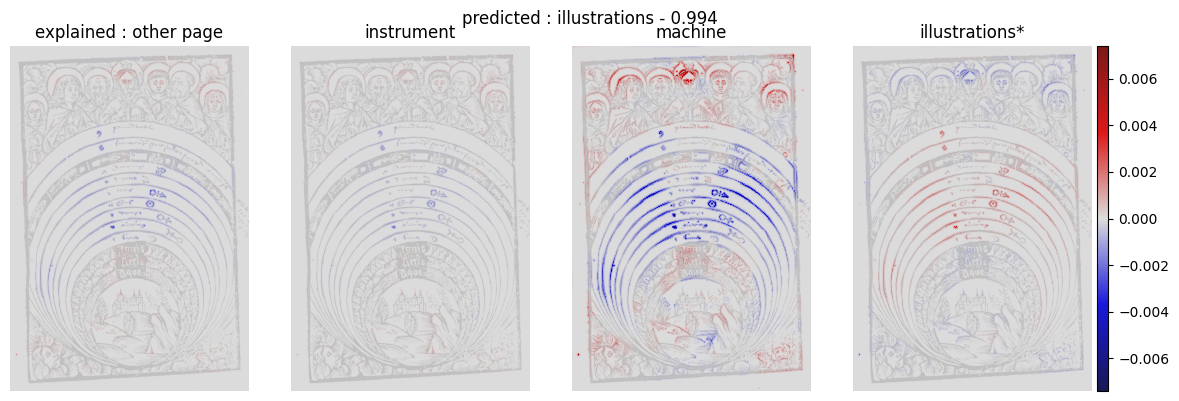

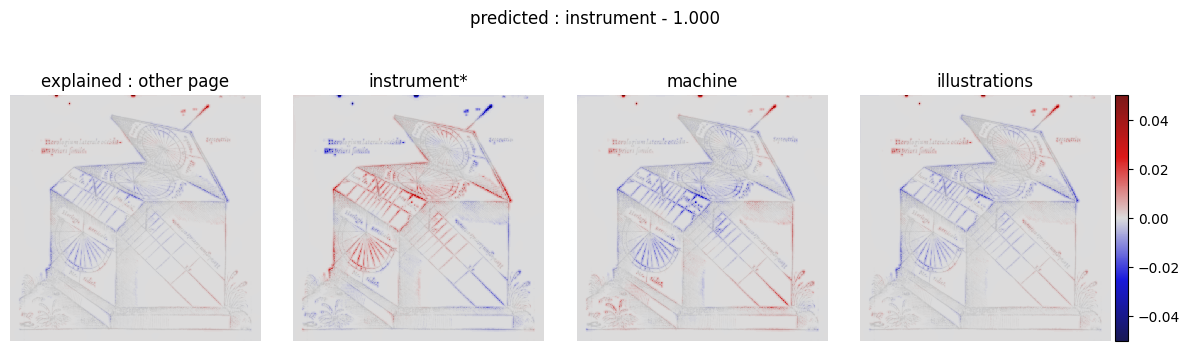

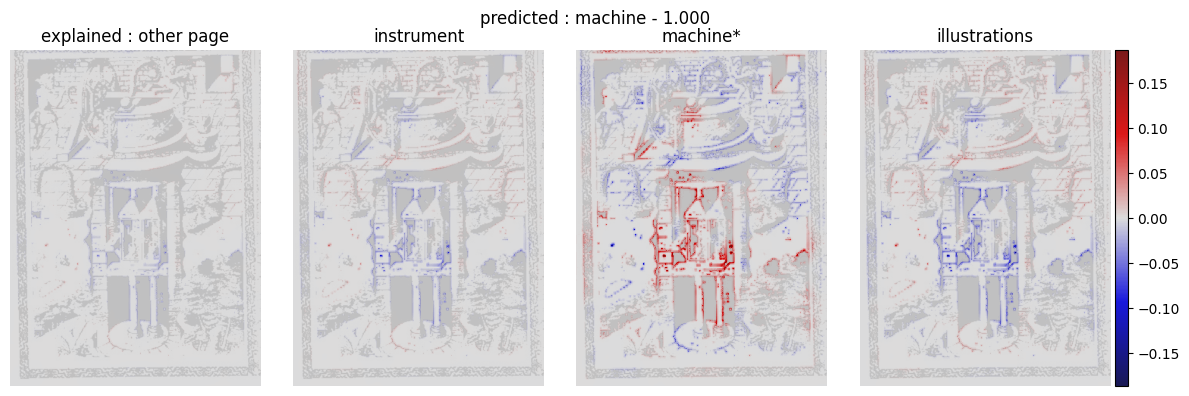

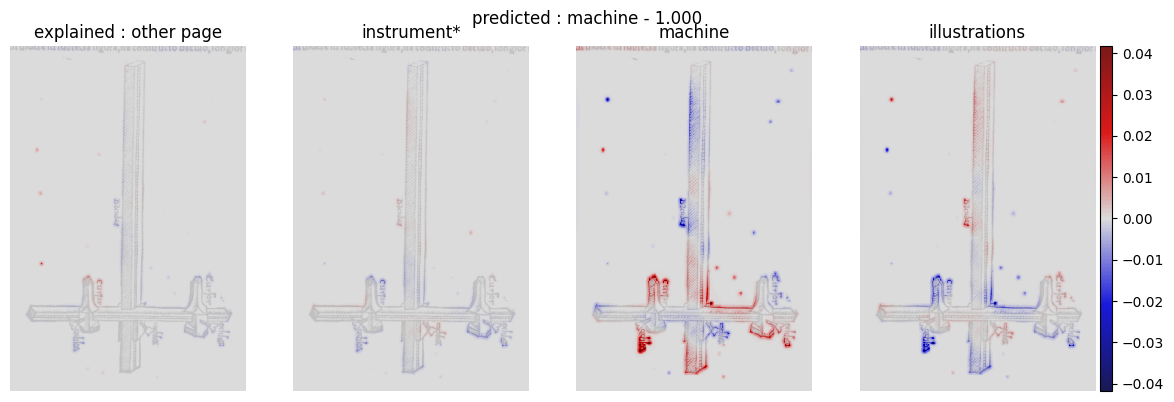

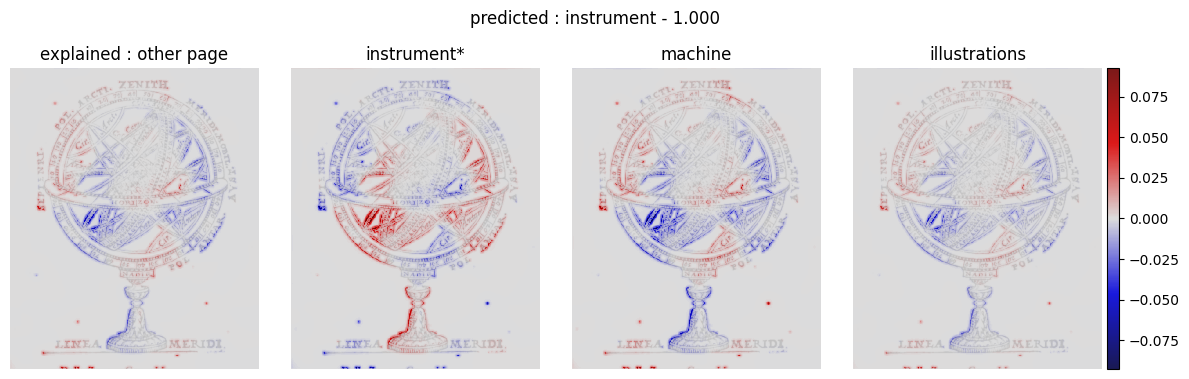

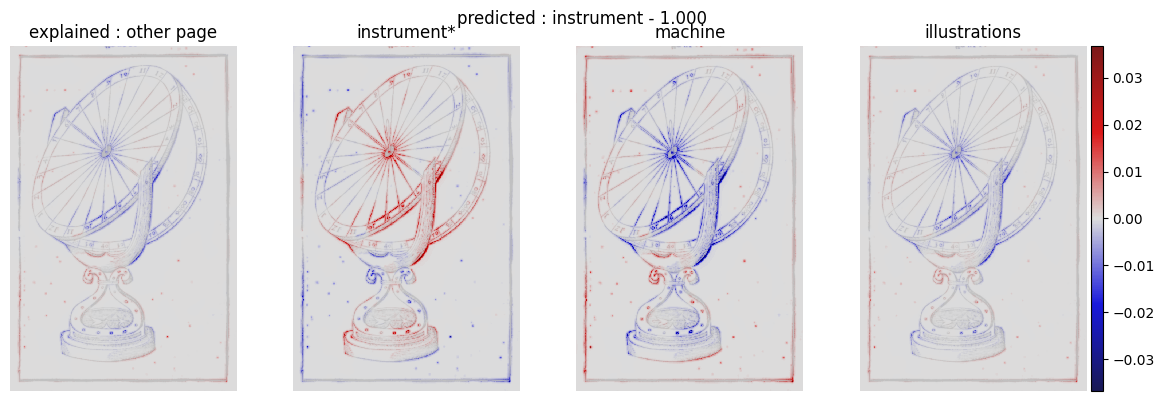

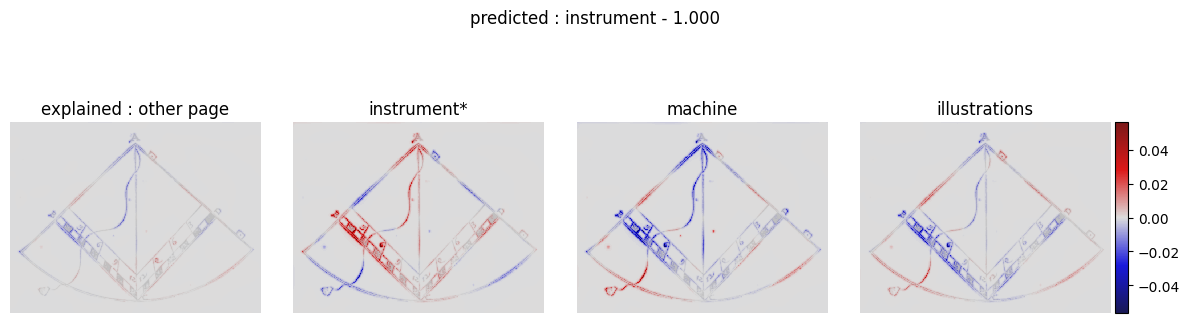

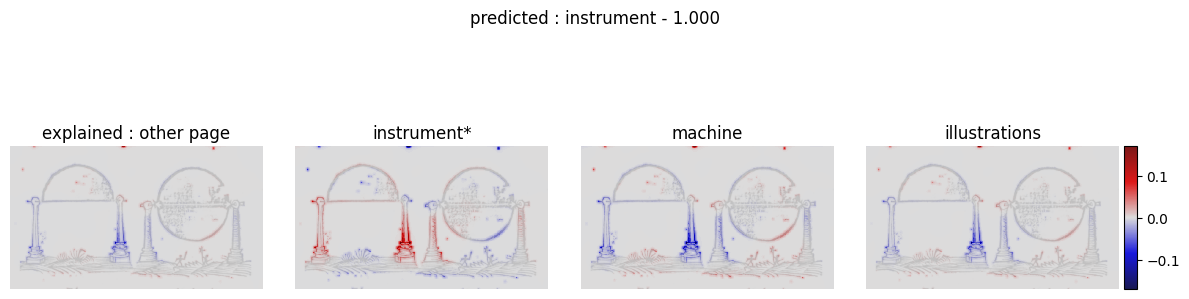

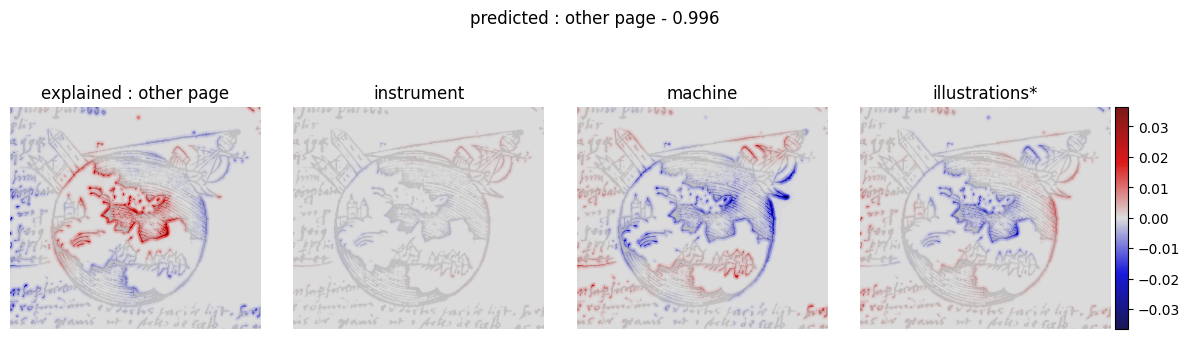

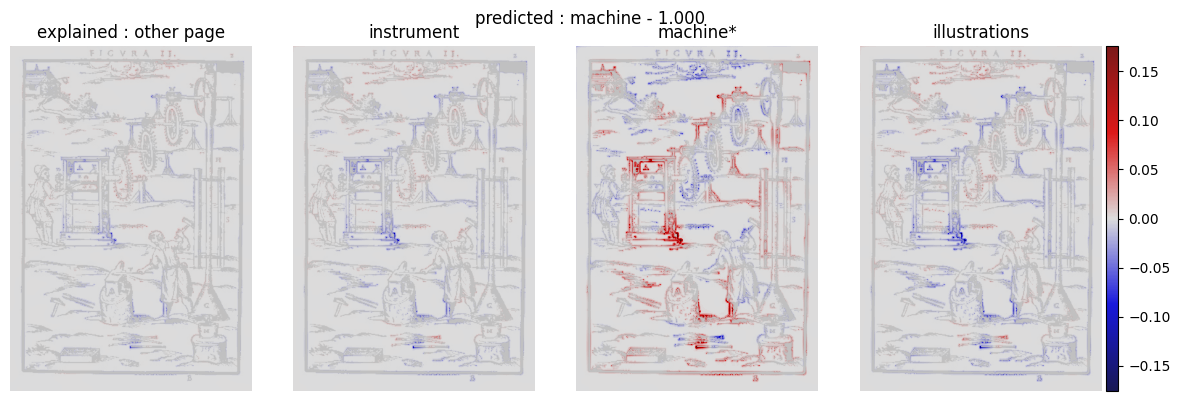

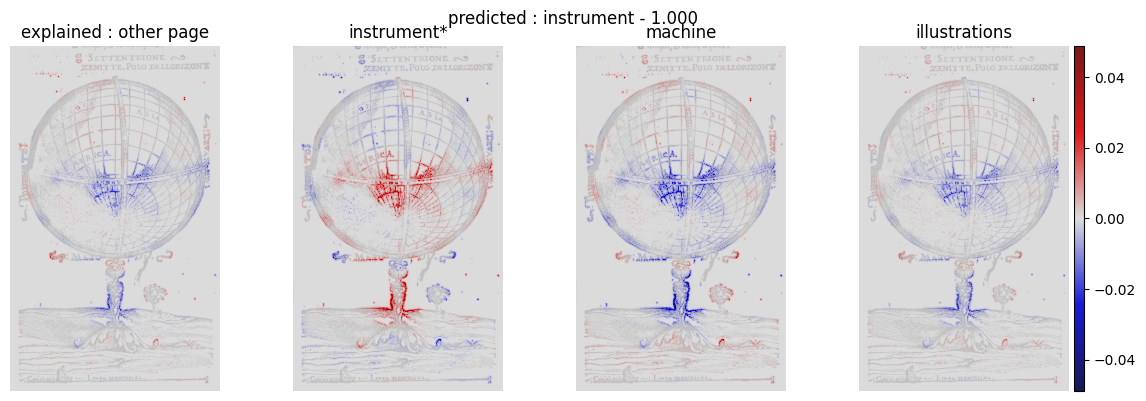

In [6]:
from xai import explain, get_prediction, plot_heatmap

title_map = {0: 'other page', 1: 'instrument', 2: 'machine', 3: 'illustrations'}

j=0
for x in dataloader['train']:

    y_pred, logits, probs =  get_prediction(model, x[0], device)
    cases = [i for i in sorted(title_map.keys())]
    y_true = int(x[2][j])
    confidence = '{:0.4f}'.format(probs[y_true])

    R_dict = {k: None for k in cases}

    for l,cl  in enumerate(cases):

        R_ = explain(model, x[0].to(device), cl=cl, device=device, n_classes=len(title_map))
        R = np.array(R_[0][0].detach().cpu().numpy()).sum(axis=0)
        R_dict[cl] = R

    f, axs = plt.subplots(1,len(title_map), figsize=(12.,4.0))
    b = np.max([10*((np.abs(R)**3.0).mean()**(1.0/3)) for R in R_dict.values()])
    for l, cl in enumerate(cases):
        title_map_ = {k:v for k,v in title_map.items()}
        title_map_[y_true] += '*'
        plot_heatmap(R_dict[cl], x[0].squeeze()[0], (f,axs[l]), l, title_map_, cl, b)

    f.tight_layout()
    f.suptitle('predicted : {} - {:0.3f}'.format(title_map[y_pred], probs[y_pred]), y=0.99) #0.91)
    plt.subplots_adjust(top=0.9)
    plt.show()

